In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor

import optuna

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.style.use('ggplot')

In [4]:
train_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

# 1. Exploratory Data Analysis

## 1.1 First Look On The Data

In [5]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [6]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_df.drop(columns='Id', axis=1, inplace=True)
test_df.drop(columns='Id', axis=1, inplace=True)

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [9]:
train_df.describe(include='object').T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## 1.2 Nulls And Duplicates

In [11]:
train_df.duplicated().sum()

0

In [12]:
missing_values_df = pd.DataFrame(train_df.isna().sum().loc[lambda x: x>0].sort_values(ascending=False),
                                 columns=['count'])
missing_values_df['percentage'] = np.round(missing_values_df['count'] / train_df.shape[0], 3)
missing_values_df.style.background_gradient('coolwarm')

,count,percentage
PoolQC,1453,0.995000
MiscFeature,1406,0.963000
Alley,1369,0.938000
Fence,1179,0.808000
MasVnrType,872,0.597000
FireplaceQu,690,0.473000
LotFrontage,259,0.177000
GarageType,81,0.055000
GarageYrBlt,81,0.055000
GarageFinish,81,0.055000


In [13]:
numerical_features = train_df.select_dtypes(exclude="object")
categorical_features = train_df.select_dtypes(include="object")

In [14]:
numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [15]:
plt.figure(figsize=(12, 40))
columns = list(numerical_features.columns)
columns.remove('SalePrice')

for idx, column in enumerate(columns, 1):
    ax = plt.subplot(int(len(numerical_features.columns)/3), 3, idx)
    sns.scatterplot(data=numerical_features, x=column, y='SalePrice',
                    hue='SalePrice', palette='viridis_r', ax=ax)
    
plt.tight_layout()
plt.show();

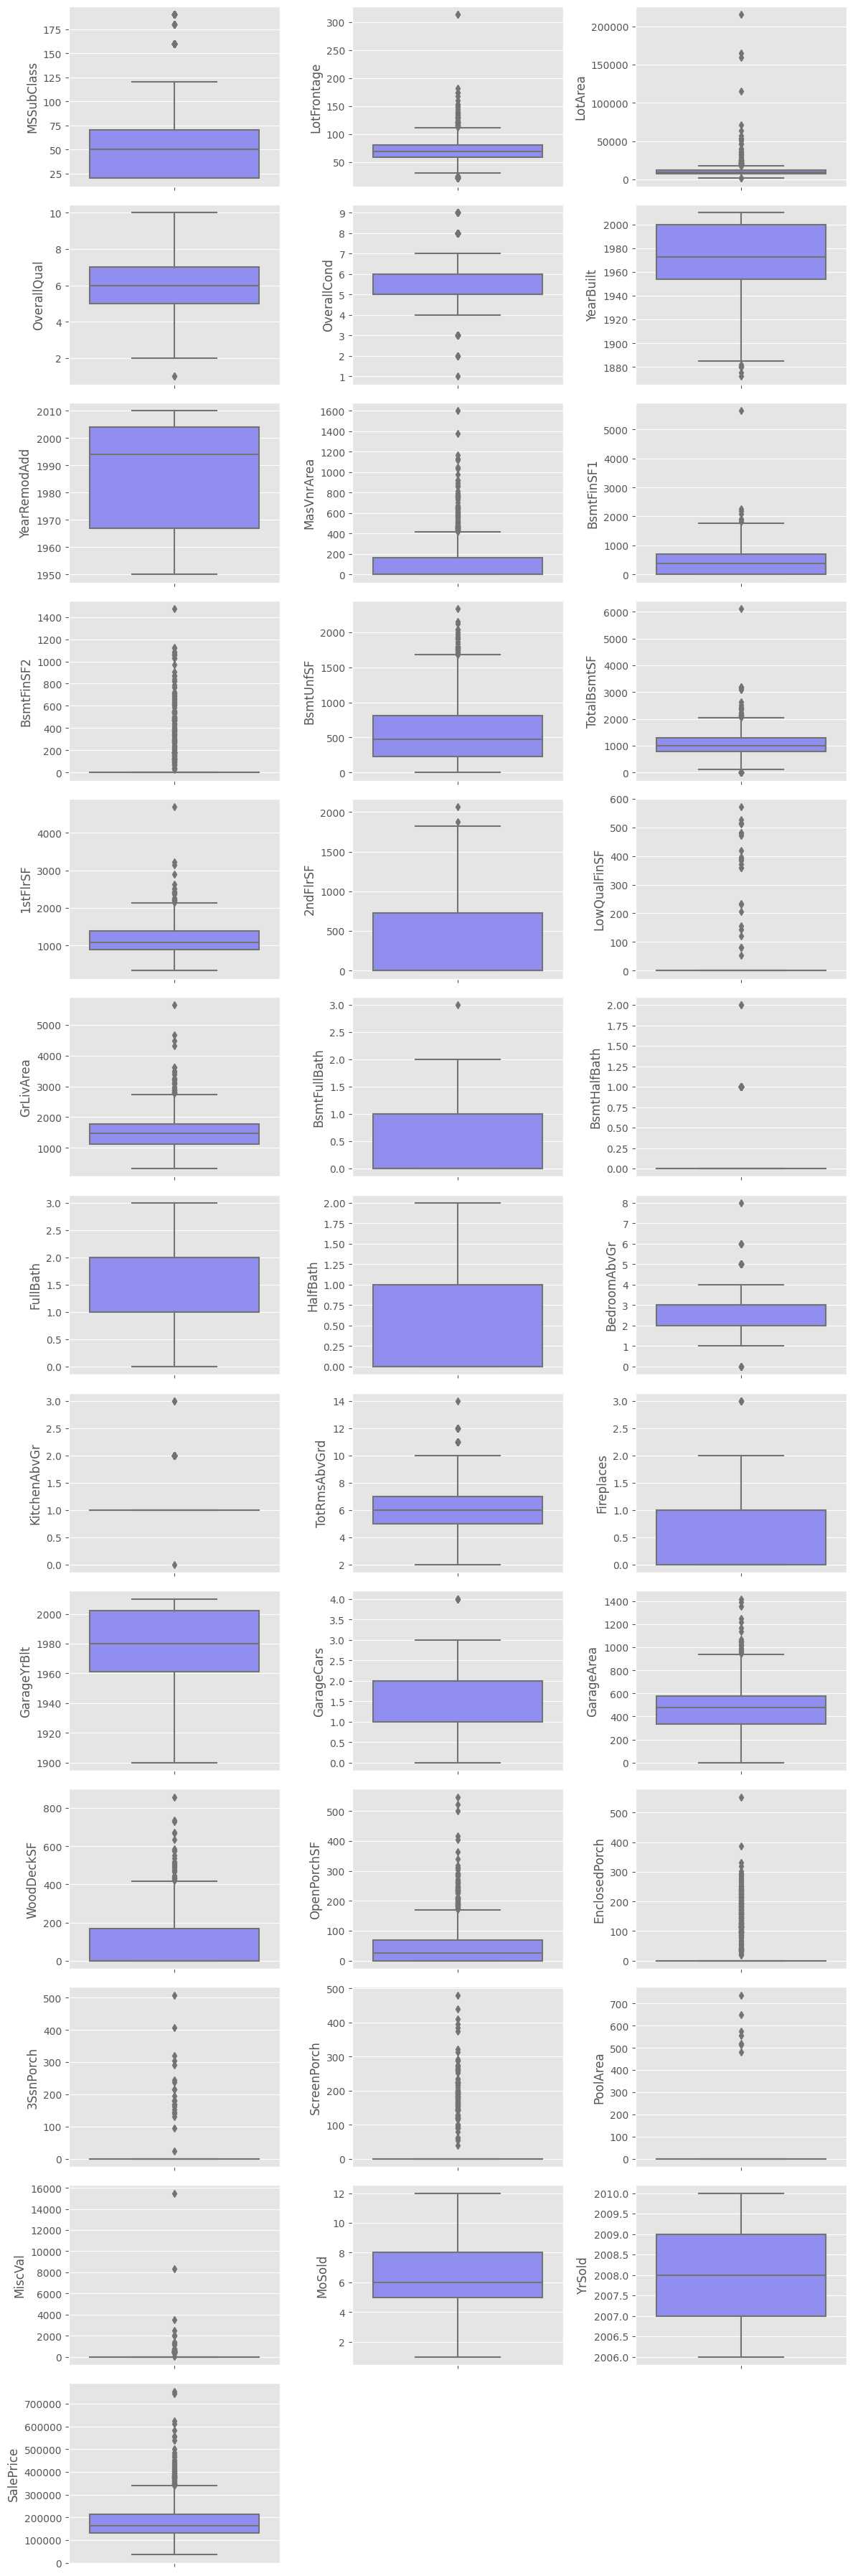

In [16]:
import math
plt.figure(figsize=(12, 36))
columns = list(numerical_features.columns)

for idx, column in enumerate(columns, 1):
    ax = plt.subplot(math.ceil(len(numerical_features.columns)/3), 3, idx)
    sns.boxplot(data=numerical_features, y=column, palette='cool', ax=ax)
    
plt.tight_layout()
plt.show();

## 1.3 Correlations

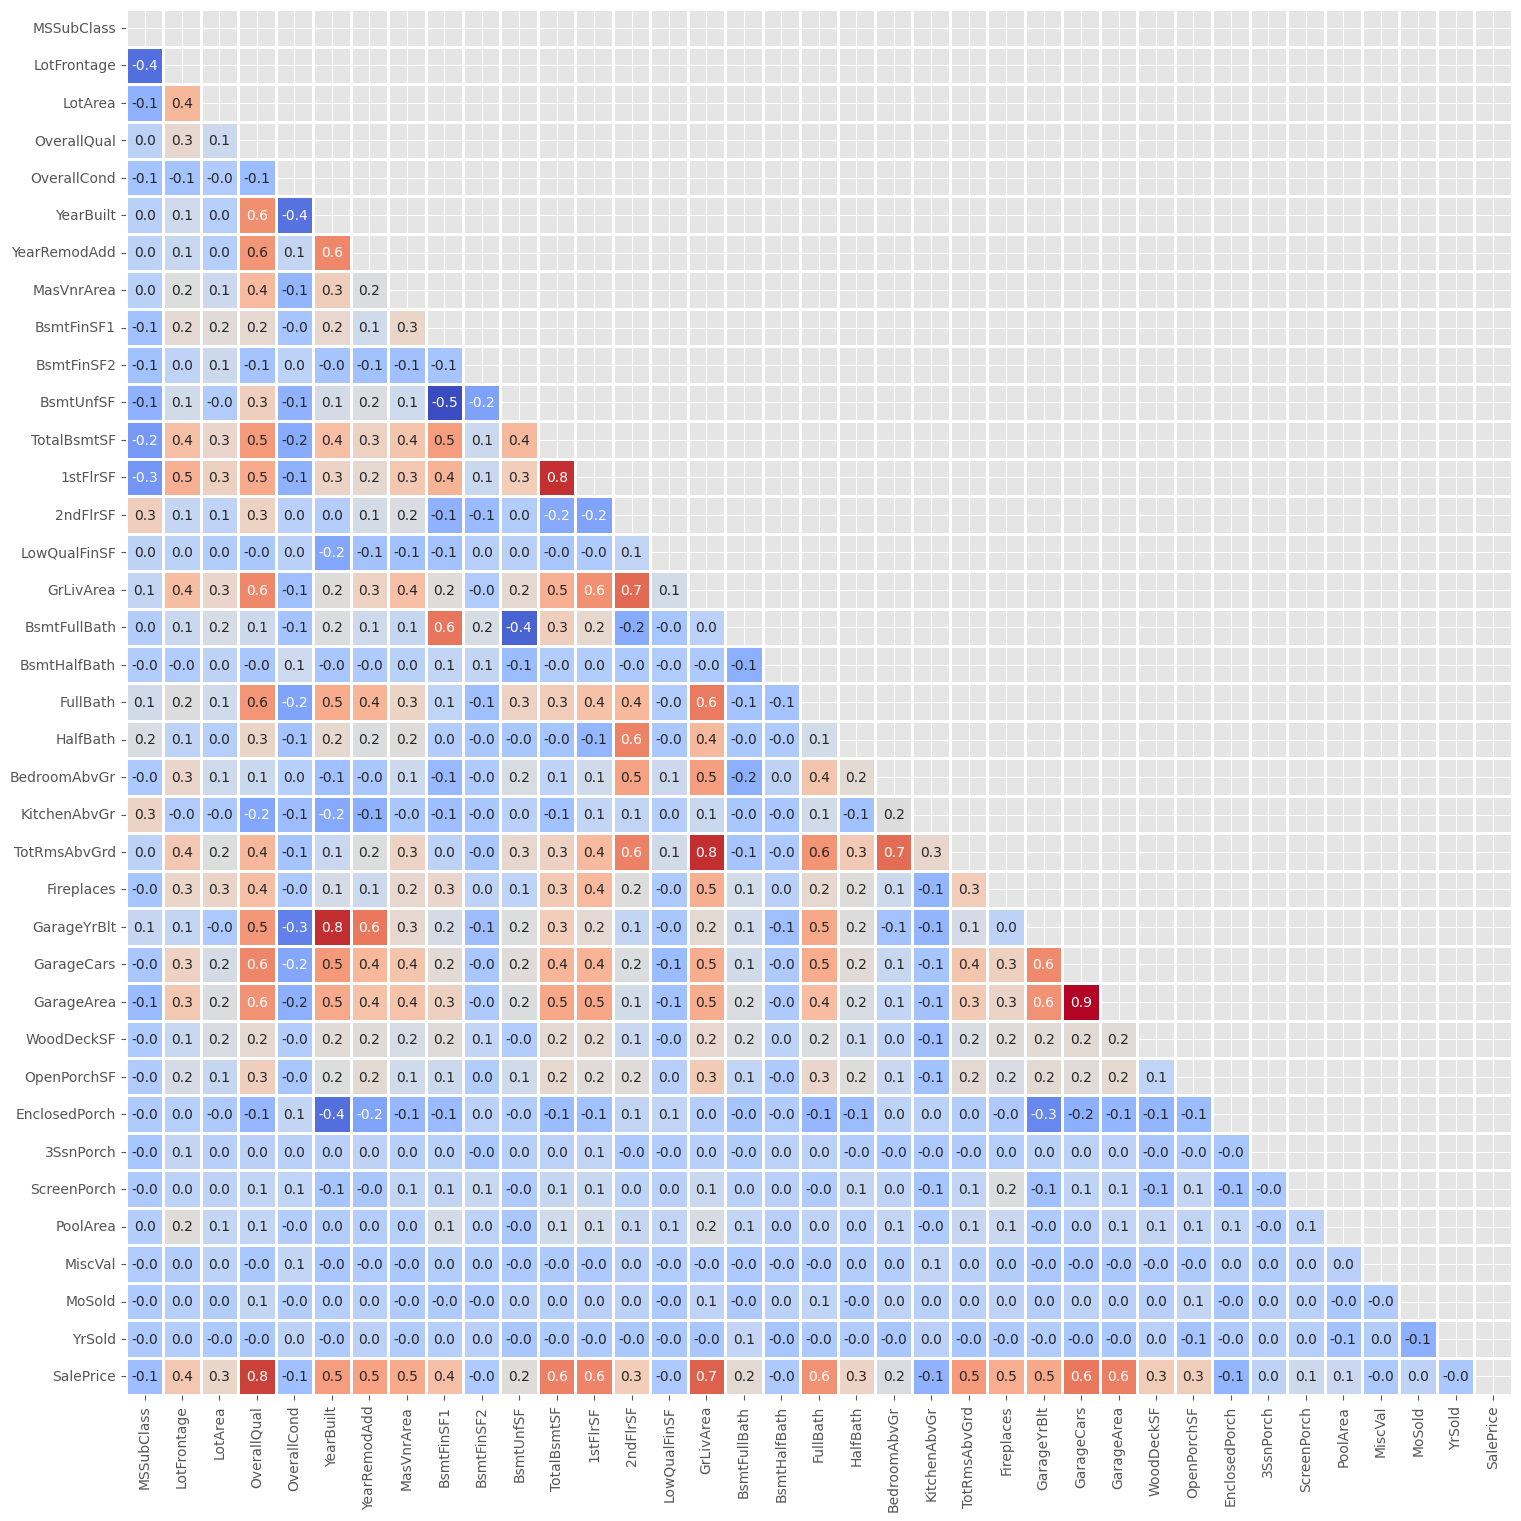

In [17]:
plt.figure(figsize=(18, 18))
numerical_features_corr_matrix = numerical_features.corr()
mask = np.triu(numerical_features_corr_matrix)

sns.heatmap(numerical_features_corr_matrix, square=True,
            annot=True, fmt='.1f', 
            cmap='coolwarm', cbar=False,
            linewidths=1, mask=mask);

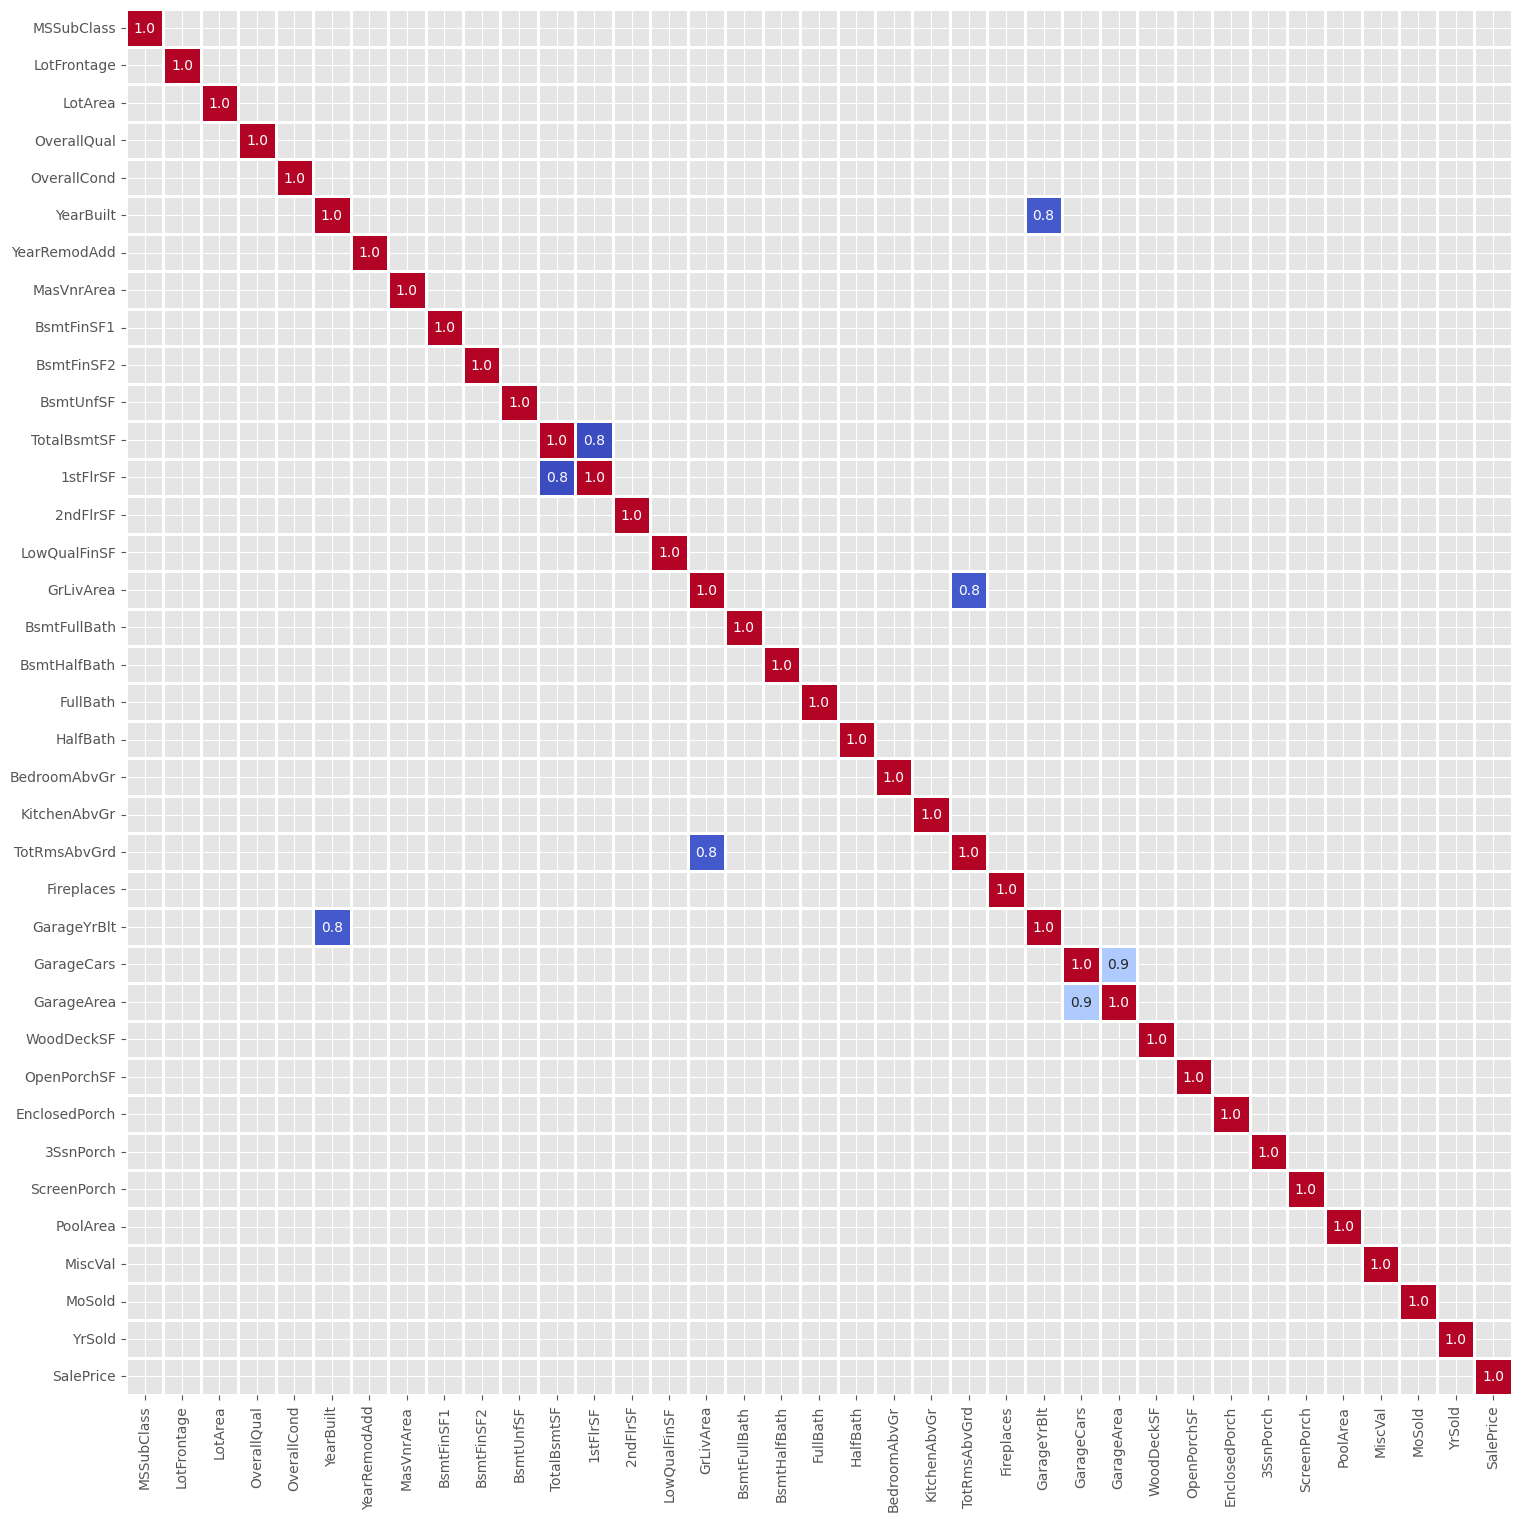

In [18]:
plt.figure(figsize=(18, 18))
numerical_features_corr_matrix = numerical_features.corr()

sns.heatmap(numerical_features_corr_matrix, square=True,
            annot=True, fmt='.1f', 
            cmap='coolwarm', cbar=False,
            linewidths=1, mask=numerical_features_corr_matrix<0.8);

In [19]:
mutual_info = pd.Series(mutual_info_regression(numerical_features.iloc[:, :-1].fillna(0),
                                               numerical_features['SalePrice']))

mutual_info.index = numerical_features.iloc[:, :-1].columns
mutual_info = pd.DataFrame(mutual_info, columns=['Value'])
mutual_info.sort_values(by='Value', ascending=False).style.background_gradient('rocket_r')

,Value
OverallQual,0.557138
GrLivArea,0.481813
TotalBsmtSF,0.368573
GarageCars,0.364640
YearBuilt,0.363074
GarageArea,0.358929
1stFlrSF,0.310060
MSSubClass,0.270388
FullBath,0.266116
GarageYrBlt,0.257070


In [20]:
mutual_info_categorical = categorical_features

for col in mutual_info_categorical.columns:
    mutual_info_categorical[col], _ = mutual_info_categorical[col].factorize()

mutual_info = pd.Series(mutual_info_regression(mutual_info_categorical.fillna('Missing'),
                                               numerical_features['SalePrice']))

mutual_info.index = mutual_info_categorical.columns

mutual_info = pd.DataFrame(mutual_info, columns=['Value'])
mutual_info.sort_values(by='Value', ascending=False).style.background_gradient('rocket_r')

,Value
BsmtQual,0.332524
KitchenQual,0.331948
ExterQual,0.328050
GarageFinish,0.265610
GarageType,0.208790
Foundation,0.193567
HeatingQC,0.164255
MSZoning,0.130741
Neighborhood,0.130734
MasVnrType,0.098890


# 2. Feature Engineering

## 2.1 Feature Creation

In [21]:
df = pd.concat([train_df, test_df], axis=0)

In [22]:
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['HouseYrSinceRemod'] = df['YearRemodAdd'] - df['YearBuilt']
df['Quality'] = df['OverallQual'] + df['OverallCond']
df['Baths'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] \
                    + df['3SsnPorch'] + df['ScreenPorch']
df['BsmtFinToTotalBsmtSF'] = (df['BsmtFinSF1'] + df['BsmtFinSF2']) / df['TotalBsmtSF']
df['GrLivAreaToTotalSF'] = df['GrLivArea'] / df['TotalSF']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [23]:
numerical_features = df.select_dtypes(include=np.number)
categorical_features = df.select_dtypes(exclude=np.number)

In [24]:
numerical_df = df.select_dtypes(include=np.number)
numerical_df = numerical_df[numerical_df['SalePrice'].isna() == False].drop('SalePrice', axis=1).fillna(0)
mutual_info = pd.Series(mutual_info_regression(numerical_df,
                                               train_df['SalePrice']))

mutual_info.index = numerical_df.columns
mutual_info = pd.DataFrame(mutual_info, columns=['Value'])
mutual_info.sort_values(by='Value', ascending=False).style.background_gradient('rocket_r')

,Value
TotalSF,0.679083
OverallQual,0.549464
GrLivArea,0.483315
GarageCars,0.369238
TotalBsmtSF,0.368666
GarageArea,0.365844
Quality,0.358734
YearBuilt,0.355556
Baths,0.347157
HouseAge,0.332639


## 2.2 Encoding Categorical Ordinal Features

In [25]:
ordinal_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'HeatingQC', 'KitchenQual',
               'FireplaceQu', 'GarageFinish', 'GarageQual',
               'GarageCond', 'PoolQC', 'Fence', 'CentralAir',
               'Utilities', 'LandSlope']

exterqual_map = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
extercond_map = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
bsmtqual_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmtcond_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmtexposure_map = {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmtfintype1_map = {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
bsmtfintype2_map = {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
heatingqc_map = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
kitchenqual_map = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
fireplacequ_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
garagefinish_map = {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
garagequal_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
garagecond_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
poolqc_map = {'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
fence_map = {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
centralair_map = {'N': 0, 'Y': 1}
utilities_map = {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}
landslope_map = {'Sev': 0, 'Mod': 1, 'Gtl': 2}

In [26]:
for cat in ordinal_cat:
    map_dict = cat.lower() + '_map'
    df[f'{cat}_mapped'] = df[cat].map(globals()[map_dict])
    df[f'{cat}_mapped'].fillna(0, inplace=True)

In [27]:
df.drop(columns=ordinal_cat, axis=1, inplace=True)

## 2.3 One Hot Encoding Categorical Nominal Features

In [28]:
one_hot_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 
                'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
                'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
                'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'Foundation', 'Heating', 'Electrical', 'Functional',
                'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']

In [29]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0))
])

nominal_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [30]:
nominal_t = nominal_transformer.fit(df[one_hot_cols])
x = nominal_t.transform(df[one_hot_cols]).toarray()

In [31]:
one_hot_df = pd.DataFrame(x, columns=nominal_t.get_feature_names_out())

In [32]:
one_hot_df

,MSZoning_C (all),MSZoning_FV,MSZoning_Missing,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Missing,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Missing,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Missing,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Missing,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Missing,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Missing,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Missing,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MiscFeature_Gar2,MiscFeature_Missing,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Missing,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.

In [33]:
transformed_df = df.drop(columns=one_hot_cols, axis=1)
transformed_df.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)
transformed_df = pd.concat([transformed_df, one_hot_df], axis=1)

In [34]:
transformed_df[numerical_features.columns].isna().sum()[lambda x: x>0]

LotFrontage              486
MasVnrArea                23
BsmtFinSF1                 1
BsmtFinSF2                 1
BsmtUnfSF                  1
TotalBsmtSF                1
BsmtFullBath               2
BsmtHalfBath               2
GarageYrBlt              159
GarageCars                 1
GarageArea                 1
SalePrice               1459
Baths                      2
TotalSF                    1
BsmtFinToTotalBsmtSF      79
GrLivAreaToTotalSF         1
dtype: int64

In [35]:
num_transformer = numerical_transformer.fit(transformed_df[numerical_features.columns])

In [36]:
transformed_df[numerical_features.columns] = num_transformer.transform(transformed_df[numerical_features.columns])

In [37]:
num_transformer.get_feature_names_out()

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'HouseAge', 'HouseYrSinceRemod',
       'Quality', 'Baths', 'TotalSF', 'TotalPorchSF',
       'BsmtFinToTotalBsmtSF', 'GrLivAreaToTotalSF', 'HasPool',
       'Has2ndFloor', 'HasGarage', 'HasBsmt', 'HasFireplace'],
      dtype=object)

# 3. Preparation Of Train And Test Datasets

In [38]:
sum(transformed_df.isna().sum()[lambda x: x>0])

0

In [39]:
train = transformed_df.iloc[:1460, :]
test = transformed_df.iloc[1460:, :]

In [40]:
assert train_df.shape[0] == train.shape[0]
assert test_df.shape[0] == test.shape[0]

In [41]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']

X_test = test.drop('SalePrice', axis=1)

## 3.1 Feature Selection

In [42]:
variance = transformed_df.select_dtypes(include=np.number).var()
variance.index = transformed_df.columns
variance_df = pd.DataFrame(variance, columns=['Variance'])
variance_df.sort_values(by='Variance', ascending=False).style.background_gradient('cool')

,Variance
SalePrice,11341478811.101795
LotArea,62204711.568544
TotalSF,649508.804950
MiscVal,321945.268537
GrLivArea,256087.660265
BsmtFinSF1,207576.840310
GarageYrBlt,202217.787489
TotalBsmtSF,194587.293958
BsmtUnfSF,193240.149785
2ndFlrSF,183784.937963


In [43]:
estimator = RandomForestRegressor(random_state=42)
rfe = RFE(estimator, n_features_to_select=35, step=1)

In [44]:
X_train = rfe.fit_transform(X_train, y_train)
X_test = rfe.transform(X_test)

## 3.2 Model Selection

In [45]:
models = {
    'LR':LinearRegression(),
    'KNN':KNeighborsRegressor(),
    'RF':RandomForestRegressor(),
    'GBR':GradientBoostingRegressor(),
    'XGB':XGBRegressor(),
    'XGBRF':XGBRFRegressor(),
    'CatBoost':CatBoostRegressor(verbose=False),
    'LGBM':LGBMRegressor(verbosity=-1)
}

for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -np.mean(scores['test_score'])
    print(f"RMSE for model: {name} is: {rmse}")

RMSE for model: LR is: 35590.08675699313
RMSE for model: KNN is: 45059.45134781096
RMSE for model: RF is: 29194.840359775426
RMSE for model: GBR is: 25716.94146900142
RMSE for model: XGB is: 29320.30101868866
RMSE for model: XGBRF is: 30746.33747014369
RMSE for model: CatBoost is: 26553.216032891418
RMSE for model: LGBM is: 29037.79349838785


## 3.3 Hyperparameters Tuning

In [46]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'verbose': False
    }
        
    model = CatBoostRegressor(**params)
    
    scores = cross_val_score(
        model, 
        X_train, 
        y_train, 
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    
    return -np.mean(scores)

In [49]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-03-30 09:08:23,267] A new study created in memory with name: no-name-5d9ee619-5790-49b2-9c23-7e6b8a082b7a
[I 2025-03-30 09:08:36,622] Trial 0 finished with value: 28323.145088579866 and parameters: {'iterations': 500, 'learning_rate': 0.018780949256265975, 'depth': 10, 'l2_leaf_reg': 0.0620060275884681, 'border_count': 194, 'bagging_temperature': 2.3306046637572306, 'random_strength': 6.62352751770149e-08, 'min_data_in_leaf': 13, 'rsm': 0.15201369371603524}. Best is trial 0 with value: 28323.145088579866.
[I 2025-03-30 09:08:39,164] Trial 1 finished with value: 26349.547011956398 and parameters: {'iterations': 300, 'learning_rate': 0.05701269503708156, 'depth': 6, 'l2_leaf_reg': 3.991513375269331, 'border_count': 236, 'bagging_temperature': 1.0614452936835073, 'random_strength': 1.7455202982484297e-06, 'min_data_in_leaf': 54, 'rsm': 0.3914969411216942}. Best is trial 1 with value: 26349.547011956398.
[I 2025-03-30 09:08:42,930] Trial 2 finished with value: 27775.62585859221 and

In [50]:
print("Best params:", study.best_params)
print("Best RMSE:", -study.best_value)

Best params: {'iterations': 800, 'learning_rate': 0.05472744577251467, 'depth': 4, 'l2_leaf_reg': 0.01410238409596083, 'border_count': 158, 'bagging_temperature': 6.165490029385781, 'random_strength': 0.010212676842367097, 'min_data_in_leaf': 77, 'rsm': 0.597426172468556}
Best RMSE: -25383.344825808737


In [51]:
model.set_params(**study.best_params).fit(X_train, y_train)

LGBMRegressor(bagging_temperature=6.165490029385781, border_count=158, depth=4,
              iterations=800, l2_leaf_reg=0.01410238409596083,
              learning_rate=0.05472744577251467, min_data_in_leaf=77,
              random_strength=0.010212676842367097, rsm=0.597426172468556,
              verbosity=-1)

## 3.4 Making Predictions And Creating Submission

In [52]:
preds = model.predict(X_test)

In [53]:
submition_df = pd.DataFrame({"SalePrice":preds.flatten()})

In [54]:
test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")
submition_df["Id"] = test_df["Id"]

In [55]:
submition_df = submition_df[["Id", "SalePrice"]]

In [56]:
submition_df.head(3)

,Id,SalePrice
0,1461,126624.494264
1,1462,163189.219717
2,1463,172771.069401


In [ ]:
submition_df.to_csv("submission.csv", index=False)